# Deep Learning American Sign Language with TensorFlow
This notebook creates a convolutional neural network to categorize 24 different American Sign Language alphabet signs. Due to the movements associated with the sign the letters J and Z have been skipped. The primary dataset used for training this model came from the [ASL Finger Spelling Dataset](http://empslocal.ex.ac.uk/people/staff/np331/index.php?section=FingerSpellingDataset) and involved 5 different signers with similar lighting and background. 

This notebook was developed using Python version 2.7, OpenCV version 2.4, and TensorFlow 1.4. 

## Imports

In [1]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.python.keras.layers import Dropout, Flatten, Dense
from tensorflow.python.keras.layers import Input, BatchNormalization, Activation
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint

import cPickle as pickle
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Data Preparation
The dataset is stored in a number of folders and must be collected into one directory to be properly utilized. We will only be using the color versions of the photos and will not be using the depth images - these will be ignored. 

In [129]:
imgs = []
labels = []

## Change this to the location of the dataset download
rt = ''

import os
from os.path import join, getsize
for root, dirs, files in os.walk(rt):
    for name in files: 
        if name.startswith('color'):
            img = cv2.imread(os.path.join(root, name))
            
            # Categories are either 1 or 2 digits long - this will remove the non-digit for single digit categories
            label = name[6:8] 
            label = label.replace("_", "")
            
            imgs.append(img)
            labels.append(int(label))
            
# Ensure that all files were collected
print len(imgs)
print len(labels)

0
0


In [4]:
# Convert to numpy array
labels = np.zeros(len(imgs))
print labels.shape
for i in range(len(labels)):
    ls[i] = labels[i]

(65774,)


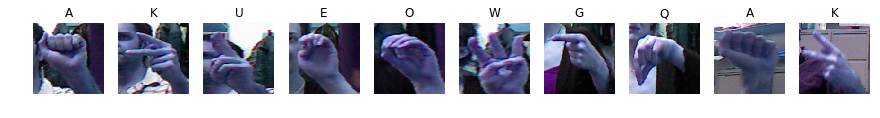

In [6]:
# Check that our inputs and outputs match up
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(0, 50000, 5000):
    ax[j].axis('off')
    ax[j].set_title(chr(int(labels[i]) + ord("A")), loc='center')
    ax[j].imshow(dataset[i,:,:,:])
    j+=1

This is only needed to save the data - don't run this unless you've collected the files from the dataset: 

In [10]:
pickle_file = 'data.pickle'
try: 
    f = open(pickle_file, 'wb')
    save = {
        'imgs': imgs,
        'labels': labels
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print "Unable to save data to", pickle_file, ':', e
    raise

If you've previously saved the data this can be used to load it more quickly:

In [2]:
pickle_file = 'data.pickle'

with open(pickle_file, 'rb') as f: 
    save = pickle.load(f)
    imgs = save['imgs']
    output = save['labels']
    del save

We will normalize the data between 0 and 1 for better model performance. We will also resize the data since they are in a variety of shapes and sizes. 150 by 150 pixels was chosen because it was roughly half the size of the largest image in the dataset. Convert the dataset to a numpy array to allow us to work with it more easily. 

In [3]:
dataset = np.zeros([len(imgs), 150, 150, 3]).astype(np.float32)
for i in range(0, len(imgs)):
    img = cv2.resize(imgs[i], (150, 150))
    img = img / np.max(img).astype(np.float32)
    dataset[i, :, :, :] = img
    
# Note that we have 3 channels - one for red, green, and blue
print dataset.shape

(65774, 150, 150, 3)


We will create an array of indices the same length as the dataset and we'll use numpy to shuffle these indices. This will allow us to use the indices to filter the dataset into training and validation sets. We have to be VERY CAREFUL to make sure that we don't mix up the labels and images - this could be disasterous to our training.

In [5]:
indices = np.arange(len(labels))
np.random.shuffle(indices)

[60734 33377 26281  5903 52057  3408 54474 25488 37355 62802]


Here we are splitting into the training and validation sets - most of the data is devoted to the training set to give the model the most information to train on. Be sure to split the labels using the same splits as the data.

In [8]:
train_data = dataset[indices[:50000]]
train_labels = labels[indices[:50000]]

In [6]:
valid_data = dataset[indices[50000:]]
valid_labels = labels[indices[50000:]]

In [9]:
print train_data.shape
print valid_data.shape

(50000, 150, 150, 3)
(15774, 150, 150, 3)


Double check that the labels and data haven't been mixed up...

Training information:


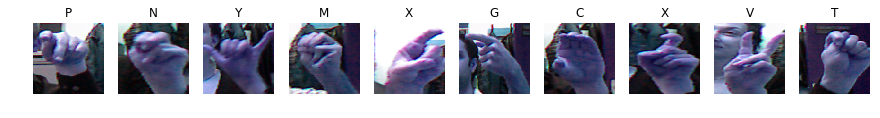

In [10]:
print "Training information:"
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(0, 10):
    ax[j].axis('off')
    ax[j].set_title(chr(int(train_labels[i]) + ord("A")), loc='center')
    ax[j].imshow(train_data[i,:,:,:])
    j+=1

Validation information:


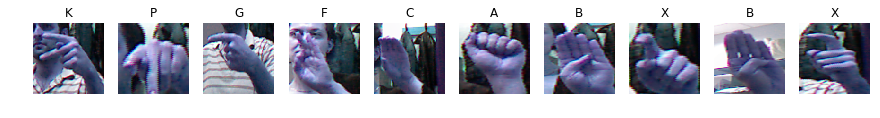

In [7]:
print "Validation information:"
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(0, 10):
    ax[j].axis('off')
    ax[j].set_title(chr(int(valid_labels[i]) + ord("A")), loc='center')
    ax[j].imshow(valid_data[i,:,:,:])
    j+=1

## Train the Model
### VGG Architecture 
This model is using the saved weights from the imagenet competition. 
First import the model. We'll need to add the 25 categories that we're classifying. We can do this by creating a sequential model and piping the VGG results to it. 

In [11]:
from tensorflow.python.keras.applications import vgg16
vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
new_layers = Sequential()
new_layers.add(Flatten(input_shape=vgg.output_shape[1:]))
new_layers.add(Dense(256, activation='relu'))
new_layers.add(Dense(25, activation='softmax'))
model = Model(inputs=vgg.input, outputs=new_layers(vgg.output))
model.summary()

57483264/58889256 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (Max

Next we will compile the model. We will use sparse categorical crossentropy because the labels have not been made into dummies. This will also give us the nice effect of being able to see *how* confident the model was in it's choices if we'd like. 

In [12]:
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

Here we will create a checkpointer to save the weights as the model trains. We'll also create a stopping function to stop the model if it isn't improving enough (if so it won't complete the number of epochs we've assigned using the epochs parameter). Finally, we fit the model to the training data using the fit function - this is where the training actually occurs. 

In [13]:
checkpointer = ModelCheckpoint(filepath='models/weights.vgg_imgnet_detection.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
best = ModelCheckpoint(filepath='saved_models/weights.best.vgg_imgnet_detection.hdf5',verbose=1, save_best_only=True)
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0025, patience=7, verbose=0, mode='auto')

model_hist = model.fit(train_data, train_labels, 
          validation_data=(valid_data, valid_labels),
          epochs=50, batch_size=64, callbacks=[checkpointer, best, stopper], verbose=1)

Train on 50000 samples, validate on 15774 samples
Epoch 1/50
50000/50000 [==============================] - 939s - loss: 0.7062 - acc: 0.7931 - val_loss: 0.0988 - val_acc: 0.9719
Epoch 2/50
50000/50000 [==============================] - 879s - loss: 0.0506 - acc: 0.9847 - val_loss: 0.0432 - val_acc: 0.9872
Epoch 3/50
50000/50000 [==============================] - 873s - loss: 0.0158 - acc: 0.9956 - val_loss: 0.0187 - val_acc: 0.9947
Epoch 4/50
50000/50000 [==============================] - 872s - loss: 0.0056 - acc: 0.9988 - val_loss: 0.0140 - val_acc: 0.9958
Epoch 5/50
50000/50000 [==============================] - 873s - loss: 0.0023 - acc: 0.9997 - val_loss: 0.0105 - val_acc: 0.9970
Epoch 6/50
50000/50000 [==============================] - 872s - loss: 6.1245e-04 - acc: 1.0000 - val_loss: 0.0097 - val_acc: 0.9973
Epoch 7/50
50000/50000 [==============================] - 871s - loss: 3.4629e-04 - acc: 1.0000 - val_loss: 0.0095 - val_acc: 0.9971
Epoch 8/50
50000/50000 [===============

Save the history if we'd like. 

In [14]:
pickle_file = "detection.pickle"

try:
  f = open(pickle_file, 'wb')
  save = {
    'history': model_hist.history
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

## Norm and Flip
The last model was rather overfit, so we'll create some more training data to give the model more information to train on. We will flip the photos along their center verticle axis, thereby mirroring the images. This will also have the affect of ensureing that if the sign is created with either the left or right hand it will be identified in either way. 

In [98]:
pickle_file = 'data.pickle'

with open(pickle_file, 'rb') as f: 
    save = pickle.load(f)
    imgs = save['imgs']
    output = save['labels']
    del save

Note: here we created some additional training data by photographing ourselves practicing the signs - here we're just loading that (note that you'd need the pickle file to be able to load it). 

In [99]:
pickle_file = 'custom_data2.pickle'

with open(pickle_file, 'rb') as f: 
    save = pickle.load(f)
    imgs2 = save['imgs']
    output2 = save['labels']
    del save

Here we norm, flip, and assign each of the images to a numpy array. Note that because we're flipping each image the output values are added twice. 

In [100]:
dataset = np.zeros([len(imgs)*2+len(imgs2)*2, 150, 150, 3]).astype(np.float32)
labels = np.zeros(len(imgs)*2+len(imgs2)*2).astype(np.int8)
j = 0
for i in range(0, len(imgs)):
    img = cv2.resize(imgs[i], (150, 150))
    img = img / np.max(img).astype(np.float32)
    dataset[j, :, :, :] = img
    j += 1
    dataset[j, :, :, :] = np.fliplr(img)
    labels[j] = output[i]
    j += 1
    labels[j] = output[i]
    
for i in range(0, len(imgs2)):
    img = imgs2[i] / np.max(imgs2[i]).astype(np.float32)
    img = img / np.max(img).astype(np.float32)
    dataset[j, :, :, :] = img
    labels[j] = output2[i]
    j += 1
    dataset[j, :, :, :] = np.fliplr(img)
    labels[j] = output2[i]
    j += 1

In [101]:
print dataset.shape
print labels.shape

(150916, 150, 150, 3)
(150916,)


Double check that we didn't mix any labels up. 

Check:


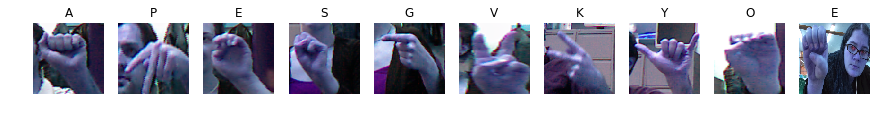

In [102]:
print "Check:"
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(0, 150000, 15000):
    ax[j].axis('off')
    ax[j].set_title(chr(int(labels[i]) + ord("A")), loc='center')
    ax[j].imshow(dataset[i,:,:,:])
    j+=1

Shuffle using the indices method as above. Note, we now have significantly more data, so we'll be creating a test set as well. 

In [103]:
indices = np.arange(len(labels))
np.random.shuffle(indices)
print indices.shape

(150916,)


In [104]:
train_data = dataset[indices[30000:]]
train_labels = labels[indices[30000:]]

In [105]:
valid_data = dataset[indices[10000:30000]]
valid_labels = labels[indices[10000:30000]]

In [106]:
test_data = dataset[indices[:10000]]
test_labels = labels[indices[:10000]]
print test_data.shape
print test_labels.shape

(10000, 150, 150, 3)
(10000,)


Check that the labels match again. 

Validation information:


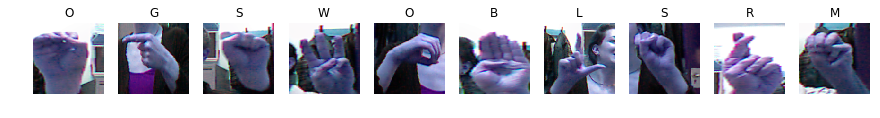

In [107]:
print "Validation information:"
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(0, 10):
    ax[j].axis('off')
    ax[j].set_title(chr(int(valid_labels[i]) + ord("A")), loc='center')
    ax[j].imshow(valid_data[i,:,:,:])
    j+=1

Training information:


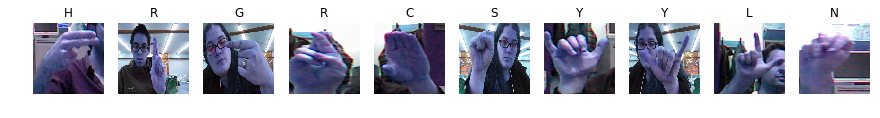

In [22]:
print "Training information:"
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(0, 10):
    ax[j].axis('off')
    ax[j].set_title(chr(int(train_labels[i]) + ord("A")), loc='center')
    ax[j].imshow(train_data[i,:,:,:])
    j+=1

Testing information:


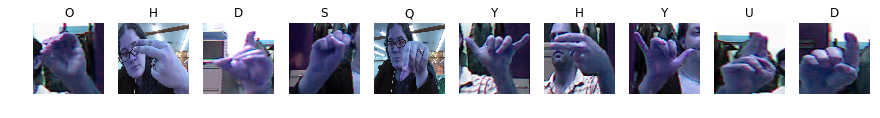

In [27]:
print "Testing information:"
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(0, 10):
    ax[j].axis('off')
    ax[j].set_title(chr(int(test_labels[i]) + ord("A")), loc='center')
    ax[j].imshow(test_data[i,:,:,:])
    j+=1

# New Model with Random Weights
Here we will also be using the VGG16 architecture, but this time we won't be using the saved Imagenet weights - we'll be starting with random weights near zero and we'll adapt them as we train the model. 

Here we load the model and add the required layers to adapt VGG16 to our training needs. 

In [28]:
from tensorflow.python.keras.applications import vgg16
vgg = vgg16.VGG16(weights=None, include_top=False, input_shape=(150, 150, 3))
new_layers = Sequential()
new_layers.add(Flatten(input_shape=vgg.output_shape[1:]))
new_layers.add(Dense(256, activation='relu'))
new_layers.add(Dense(25, activation='softmax'))
model = Model(inputs=vgg.input, outputs=new_layers(vgg.output))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Here we'll compile the model, again using sparse categorical crossentropy as our loss function.  

In [29]:
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

Here we will create another checkpointer callback and another stopping function to stop earlier than the full number of epochs if the model isn't training much anymore. Finally, we'll begin the training. 

In [31]:
checkpointer = ModelCheckpoint(filepath='models/weights.vgg_none.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
best = ModelCheckpoint(filepath='saved_models/weights.best.vgg_none.hdf5',verbose=1, save_best_only=True)
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0025, patience=5, verbose=0, mode='auto')

model_hist = model.fit(train_data, train_labels, 
          validation_data=(valid_data, valid_labels),
          epochs=50, batch_size=64, callbacks=[checkpointer, best, stopper], verbose=1)

Train on 120916 samples, validate on 20000 samples
Epoch 1/50
120916/120916 [==============================] - 378s - loss: 3.2143 - acc: 0.0455 - val_loss: 3.2097 - val_acc: 0.0490
Epoch 2/50
120916/120916 [==============================] - 377s - loss: 3.1970 - acc: 0.0458 - val_loss: 3.1889 - val_acc: 0.0490
Epoch 4/50
 75968/120916 [=================>............] - ETA: 132s - loss: 3.1811 - acc: 0.0469

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



120916/120916 [==============================] - 377s - loss: 0.7966 - acc: 0.7606 - val_loss: 0.5526 - val_acc: 0.8360
Epoch 7/50
109440/120916 [==========================>...] - ETA: 33s - loss: 0.3796 - acc: 0.8873

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



120916/120916 [==============================] - 377s - loss: 0.1313 - acc: 0.9616 - val_loss: 0.1658 - val_acc: 0.9531
Epoch 10/50
120916/120916 [==============================] - 377s - loss: 0.0894 - acc: 0.9741 - val_loss: 0.1682 - val_acc: 0.9530
Epoch 11/50
 13888/120916 [==>...........................] - ETA: 315s - loss: 0.0598 - acc: 0.9829

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



120916/120916 [==============================] - 377s - loss: 0.0470 - acc: 0.9869 - val_loss: 0.1089 - val_acc: 0.9719
Epoch 13/50
120916/120916 [==============================] - 377s - loss: 0.0370 - acc: 0.9897 - val_loss: 0.1135 - val_acc: 0.9733
Epoch 14/50
 46080/120916 [==========>...................] - ETA: 220s - loss: 0.0285 - acc: 0.9926

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



120916/120916 [==============================] - 376s - loss: 0.0231 - acc: 0.9946 - val_loss: 0.0941 - val_acc: 0.9770
Epoch 16/50
120916/120916 [==============================] - 376s - loss: 0.0226 - acc: 0.9944 - val_loss: 0.0861 - val_acc: 0.9817
Epoch 17/50
 70912/120916 [================>.............] - ETA: 146s - loss: 0.0203 - acc: 0.9953

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



120916/120916 [==============================] - 376s - loss: 0.0118 - acc: 0.9981 - val_loss: 0.0857 - val_acc: 0.9829
Epoch 20/50
 90368/120916 [=====================>........] - ETA: 89s - loss: 0.0110 - acc: 0.9979

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



120916/120916 [==============================] - 375s - loss: 0.0125 - acc: 0.9980 - val_loss: 0.0801 - val_acc: 0.9847
Epoch 23/50
113984/120916 [===========================>..] - ETA: 20s - loss: 0.0090 - acc: 0.9988

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 00023: val_loss did not improve
120916/120916 [==============================] - 375s - loss: 0.0101 - acc: 0.9984 - val_loss: 0.0874 - val_acc: 0.9828
Epoch 25/50
120916/120916 [==============================] - 375s - loss: 0.0095 - acc: 0.9986 - val_loss: 0.0811 - val_acc: 0.9849
Epoch 26/50
120916/120916 [==============================] - 375s - loss: 0.0073 - acc: 0.9992 - val_loss: 0.0926 - val_acc: 0.9826


It can be very helpful to learn from our mistakes - here we will make predictions on the test images using the trained model (note that this won't train the model). We will then compare those predictions to the ground truth to get the final accuracy of the model. 

In [42]:
failures = []
test_result = []
correct = 0
predictions = model.predict(test_data)
print predictions.shape
for i in range(len(predictions)): 
    test_result.append(np.argmax(predictions[i]))
    if test_result[i] == test_labels[i]: 
        correct += 1
    else: 
        failures.append((test_data[i], test_result[i], test_labels[i]))
print correct / float(len(test_labels))

(10000, 25)
0.981


Here we will look at the mistakes our model made. We will compare the predicted category against the actual category and we'll view the image that was incorrectly classified. This can be very informative because we may notice trends that we could attempt to correct. 

Model Failures:


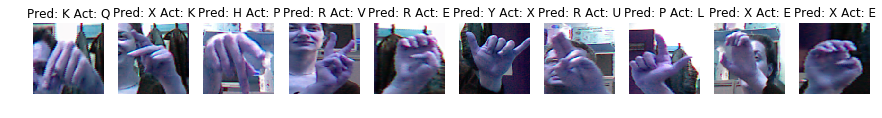

In [50]:
print "Model Failures:"
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(0, 10):
    ax[j].axis('off')
    ax[j].set_title("Pred: " + chr(int(failures[i][1]) + ord("A")) + " Act: " + chr(int(failures[i][2]) + ord("A")), loc='center')
    ax[j].imshow(failures[i][0])
    j+=1

In this particul case our model is doing a great job of correctly predicting the meaning of a sign, but it hasn't seen a single example of a photo that doesn't contain a sign! We will expand our dataset to include images that don't contain an ASL sign, including both images of hands that aren't currently in the shape of a sign and images of faces and backgrounds without hands. 

Here we'll load in a file of 'negatives' to prepare for training. 

In [109]:
pickle_file = 'negs.pickle'

with open(pickle_file, 'rb') as f: 
    save = pickle.load(f)
    imgs3 = save['imgs']
    output3 = save['labels']
    del save

Now we'll norm, flip, and prepare this new data for use with numpy. 

In [112]:
dataset2 = np.zeros([7728*2, 150, 150, 3]).astype(np.float32)
labels2 = np.zeros(7728*2).astype(np.int8)
j = 0
for i in range(0, len(imgs3)):
    img = cv2.resize(imgs3[i], (150, 150))
    img = img / np.max(img).astype(np.float32)
    dataset2[j, :, :, :] = img
    labels2[j] = 9
    j += 1
    dataset2[j, :, :, :] = np.fliplr(img)
    labels2[j] = 9
    j += 1
    
print dataset2.shape
print labels2.shape

(15456, 150, 150, 3)
(15456,)


We will add portions of this data to our train, validation, and test sets and shuffle them once more. 

In [113]:
indices = np.arange(len(train_data)+7728)
np.random.shuffle(indices)
train_data = train_data
train_data = np.append(train_data, dataset2[:7728], axis=0)
train_data = train_data[indices]
train_labels = np.append(train_labels, labels2[:7728], axis=0)
train_labels = train_labels[indices]
print train_data.shape
print train_labels.shape

(128644, 150, 150, 3)
(128644,)


In [114]:
train_data = np.append(train_data, dataset2[7728:10000], axis=0)
train_labels = np.append(train_labels, labels2[7728:10000], axis=0)
indices = np.arange(len(train_data))
np.random.shuffle(indices)
train_data = train_data[indices]
train_labels = train_labels[indices]
print train_data.shape
print train_labels.shape

(130916, 150, 150, 3)
(130916,)


Check that the labels and images match.

Training information:


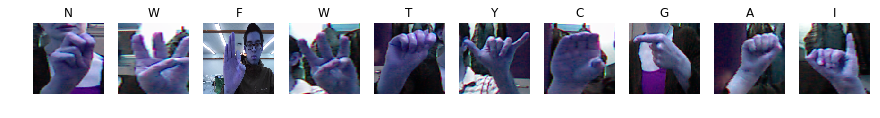

In [141]:
print "Training information:"
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(100, 110):
    ax[j].axis('off')
    ax[j].set_title(chr(int(train_labels[i]) + ord("A")), loc='center')
    ax[j].imshow(train_data[i,:,:,:])
    j+=1

In [120]:
test_data = np.append(test_data, dataset2[10000:12000], axis=0)
indices = np.arange(len(test_data))
np.random.shuffle(indices)
test_data = test_data[indices]
test_labels = np.append(test_labels, labels2[10000:12000], axis=0)
test_labels = test_labels[indices]
print test_data.shape
print test_labels.shape

(12000, 150, 150, 3)
(12000,)


In [121]:
print valid_data.shape

(20000, 150, 150, 3)


In [122]:
valid_data = np.append(valid_data, dataset2[12000:], axis=0)
indices = np.arange(len(valid_data))
np.random.shuffle(indices)
valid_data = valid_data[indices]
valid_labels = np.append(valid_labels, labels2[12000:], axis=0)
valid_labels = valid_labels[indices]
print valid_data.shape
print valid_labels.shape

(23456, 150, 150, 3)
(23456,)


## Continue Training the Model
Here will we continue training on the model that we previously trained (the VGG16 model that did not use the Imagenet weights). Because we're adding images that are unlike anything the model has seen before we'd expect the accuracy to drop from the previous training section, but ot slowly rise as it begins to correctly classify those images. 

In [123]:
checkpointer = ModelCheckpoint(filepath='models/weights.vgg_none.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
best = ModelCheckpoint(filepath='saved_models/weights.best.vgg_none.hdf5',verbose=1, save_best_only=True)
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0025, patience=3, verbose=0, mode='auto')

model_hist = model.fit(train_data, train_labels, 
          validation_data=(valid_data, valid_labels),
          epochs=22, batch_size=64, callbacks=[checkpointer, best, stopper], verbose=1)

Train on 130916 samples, validate on 23456 samples
Epoch 1/22
130916/130916 [==============================] - 411s - loss: 1.0382 - acc: 0.9322 - val_loss: 0.4726 - val_acc: 0.9931
Epoch 2/22
130916/130916 [==============================] - 410s - loss: 1.0176 - acc: 0.9380 - val_loss: 0.4504 - val_acc: 0.9930
Epoch 3/22
130916/130916 [==============================] - 410s - loss: 1.0122 - acc: 0.9387 - val_loss: 0.4189 - val_acc: 0.9966
Epoch 4/22
130916/130916 [==============================] - 410s - loss: 1.0071 - acc: 0.9395 - val_loss: 0.3911 - val_acc: 0.9959
Epoch 5/22
130916/130916 [==============================] - 409s - loss: 1.0019 - acc: 0.9398 - val_loss: 0.3454 - val_acc: 0.9971
Epoch 6/22
130916/130916 [==============================] - 409s - loss: 0.9957 - acc: 0.9398 - val_loss: 0.2819 - val_acc: 0.9972
Epoch 7/22
130916/130916 [==============================] - 409s - loss: 0.9893 - acc: 0.9389 - val_loss: 0.1934 - val_acc: 0.9959
Epoch 8/22
130916/130916 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



130916/130916 [==============================] - 408s - loss: 0.9583 - acc: 0.9404 - val_loss: 0.0207 - val_acc: 0.9971


Now we'll check the testing results. Note that some of the training data was mixed into the testing set for this test - this result is suspect! This was due to an earlier typo that has since been corrected. 

In [124]:
failures = []
test_result = []
correct = 0
predictions = model.predict(test_data)
print predictions.shape
for i in range(len(predictions)): 
    test_result.append(np.argmax(predictions[i]))
    if test_result[i] == test_labels[i]: 
        correct += 1
    else: 
        failures.append((test_data[i], test_result[i], test_labels[i]))
print correct / float(len(test_labels))

(12000, 25)
0.997666666667


Once again, we'll check which images the model had the most trouble with. 

Model Failures:


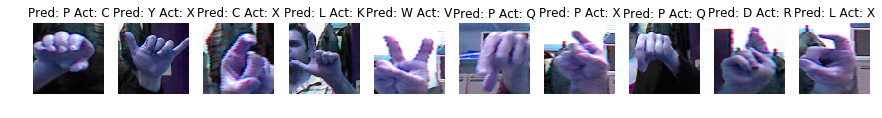

In [125]:
print "Model Failures:"
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)
j = 0
for i in range(0, 10):
    ax[j].axis('off')
    ax[j].set_title("Pred: " + chr(int(failures[i][1]) + ord("A")) + " Act: " + chr(int(failures[i][2]) + ord("A")), loc='center')
    ax[j].imshow(failures[i][0])
    j+=1